# MMP registration and Polscope mask

In [1]:
import SimpleITK as sitk

import numpy as np
import numpy.ma as ma

from myshow import myshow

import os
import sys
PolDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/Polscope_BasicCorrected/"
MMPDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/MMP input/"
OutDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/Reg Mask Output/"

#module_path = os.path.abspath(os.path.join('C:/Users/mpinkert/Documents/GitHub/SimpleITK-Notebooks/Utilities/'))
#if module_path not in sys.path:
 #   sys.path.append(module_path)
    
#from downloaddata import fetch_data as fdata

# setup our plotting environment
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = fig_size[0]*2
fig_size[1] = fig_size[1]*2
plt.rcParams["figure.figsize"] = fig_size


## Utility functions

In [2]:
def polToDegree(itkImg, ceiling):
    # Change from 16 bit integer, to a degrees.
    retImg = itkImg * (ceiling/65535) * (4/549) * 90
    return retImg

In [38]:
def affine_registration(fixed_image, moving_image, fixedMask = None, movingMask = None):
    registration_method = sitk.ImageRegistrationMethod()

     # Similarity metric settings.|
    #registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricAsMattesMutualInformation()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(1)

    registration_method.SetInterpolator(sitk.sitkLinear)

    if fixedMask:
        registration_method.SetMetricFixedMask(fixedMask)
        
    if movingMask:
        registration_method.SetMetricMovingMask(movingMask)
    
        # Optimizer settings.
    registration_method.SetOptimizerAsRegularStepGradientDescent(20.0, 0.01, 200)
    #registration_method.SetOptimizerAsOnePlusOneEvolutionary(numberOfIterations=100)
    #registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-4, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

        # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [16,8,4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2,2,1,1])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        #Redefining initial_transform so the function 
    transform = sitk.AffineTransform(2)
    #transform = sitk.TranslationTransform(2)
    
    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(transform)

        # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method, fixed_image, moving_image,transform))

    #affine_transform = registration_method.Execute(fixed_image,moving_image)
    #print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    #print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

    return (registration_method.Execute(fixed_image,moving_image), registration_method.GetMetricValue(), registration_method.GetOptimizerStopConditionDescription())

In [70]:
def affine_registration_fineRegister(fixed_image, moving_image, fixedMask = None, movingMask = None):
    registration_method = sitk.ImageRegistrationMethod()

     # Similarity metric settings.|
    #registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricAsMattesMutualInformation()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(1)

    registration_method.SetInterpolator(sitk.sitkLinear)

    if fixedMask:
        registration_method.SetMetricFixedMask(fixedMask)
        
    if movingMask:
        registration_method.SetMetricMovingMask(movingMask)
    
        # Optimizer settings.
    registration_method.SetOptimizerAsRegularStepGradientDescent(5.0, 0.001, 500)
    #registration_method.SetOptimizerAsOnePlusOneEvolutionary(numberOfIterations=100)
    #registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-4, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

        # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1,1])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        #Redefining initial_transform so the function 
    transform = sitk.AffineTransform(2)
    #transform = sitk.TranslationTransform(2)
    
    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(transform)

        # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method, fixed_image, moving_image,transform))

    #affine_transform = registration_method.Execute(fixed_image,moving_image)
    #print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    #print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

    return (registration_method.Execute(fixed_image,moving_image), registration_method.GetMetricValue(), registration_method.GetOptimizerStopConditionDescription())

In [4]:
# GUI components (sliders, dropdown...).
from ipywidgets import interact

# Enable display of HTML.
from IPython.display import clear_output


# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixedITK, movingITK):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2)
    
    fixed_npa = sitk.GetArrayFromImage(fixedITK)
    moving_npa = sitk.GetArrayFromImage(movingITK)
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    plt.show()
    
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha)*fixed + alpha*moving 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
def display_registered(fixed_image,registered_image):
    plt.imshow(sitk.GetArrayViewFromImage(registered_image), cmap=plt.cm.Reds)
    plt.hold
    plt.imshow(sitk.GetArrayViewFromImage(fixed_image),cmap=plt.cm.gray)
    
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method, fixed_image, moving_image,transform):
    global metric_values, multires_iterations
    

    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    
    alpha = 0.7
    moving_transformed = sitk.Resample(moving_image, fixed_image, transform, 
                                       sitk.sitkLinear, 0.0, 
                                       moving.GetPixelIDValue()) 
    
    #Blend the registered and fixed images                                   
    combined = (1.0 - alpha)*fixed_image + alpha*moving_transformed
    combined_eightbit = sitk.Cast(sitk.RescaleIntensity(combined), sitk.sitkUInt8)  
    
    #plot the current image
    #plt.subplots(1,2)
    fig, (ax, ax2) = plt.subplots(ncols=2)
    
    #plt.subplot(1,2,1)

    ax.imshow(sitk.GetArrayFromImage(combined_eightbit),cmap=plt.cm.gray)
    
   # plt.title(multires_iterations)
        # Plot the similarity metric values

    #plt.subplot(1,2,2)
    ax2.plot(metric_values, 'r')
    ax2.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    ax2.set_xlabel('Iteration Number',fontsize=12)
    #ax2.set_ylabel('Metric Value',fontsize=12, rotation='0')
    asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    ax2.set_aspect(asp)

    plt.show()
  
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
#def convertToDegrees(polImg, retCeiling)



## Read images

Read in the fixed (Polscope) and moving (MMP) images.  The Polscope images need to be converted from nanometers to degrees, to be on the same scale as the MMP images.

In [90]:
sample = 'WP9'

fixed = polToDegree(sitk.ReadImage(PolDir + sample + '.tif', sitk.sitkFloat32),35)
moving = sitk.ReadImage(MMPDir + sample + '_MMP.tif')


fixed.SetSpacing([5.47,5.47])
moving.SetSpacing([5.75,5.75])

#moving.SetOrigin([3480,1698])
# fixed.SetOrigin([4284,2205])


## Display initial image pairs

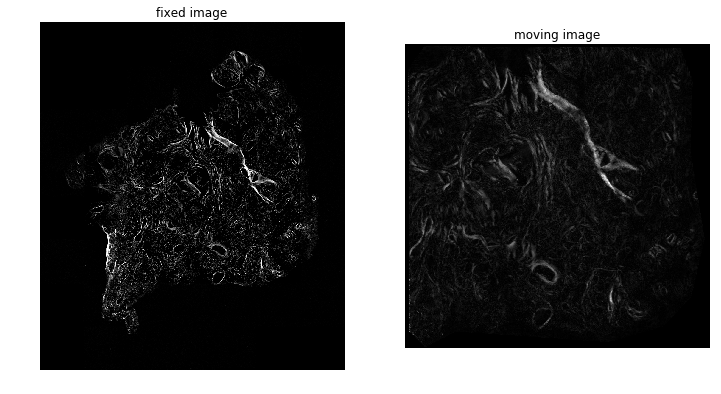

In [91]:
display_images(fixed, moving)

## Otsu segmentation and masking

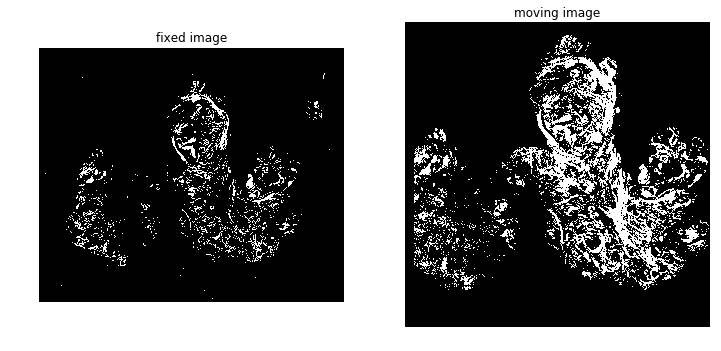

In [15]:
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)
fixedMask = otsu_filter.Execute(fixed)

#fixedMask = sitk.BinaryDilate(sitk.BinaryDilate(fixedMask))

movingMask = otsu_filter.Execute(moving)

display_images(fixedMask, movingMask)


## Affine Registration

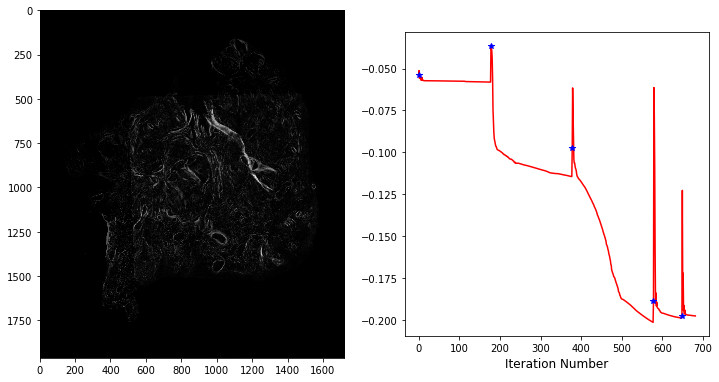

Final metric value: -0.19752790328564973
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 34 iterations. Gradient magnitude (9.48656e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (0000011F10596100)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 363828219
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.988482 -0.0289477 
     0.0279139 0.987034 
   Offset: [46.2496, -62.2461]
   Center: [0, 0]
   Translation: [46.2496, -62.2461]
   Inverse: 
     1.01082 0.0296451 
     -0.0285864 1.0123 
   Singular: 0



In [96]:

#For WP5 and WP9, the start is so far off we need to fix origin for registration.  WP5 [2500, 2000], WP9 [2600,2600]
moving.SetOrigin([2600,2600])

(transform, metric, stop) = affine_registration(fixed, moving)
print('Final metric value: {0}'.format(metric))
print('Optimizer\'s stopping condition, {0}'.format(stop))
print(transform)
#print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
#print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))


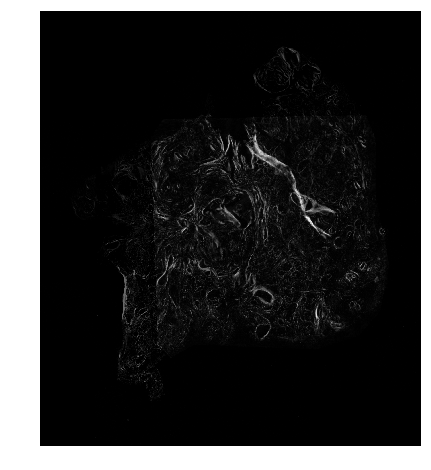

In [97]:
registered = sitk.Resample(moving, fixed, transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
display_images_with_alpha(0.7,fixed, registered)


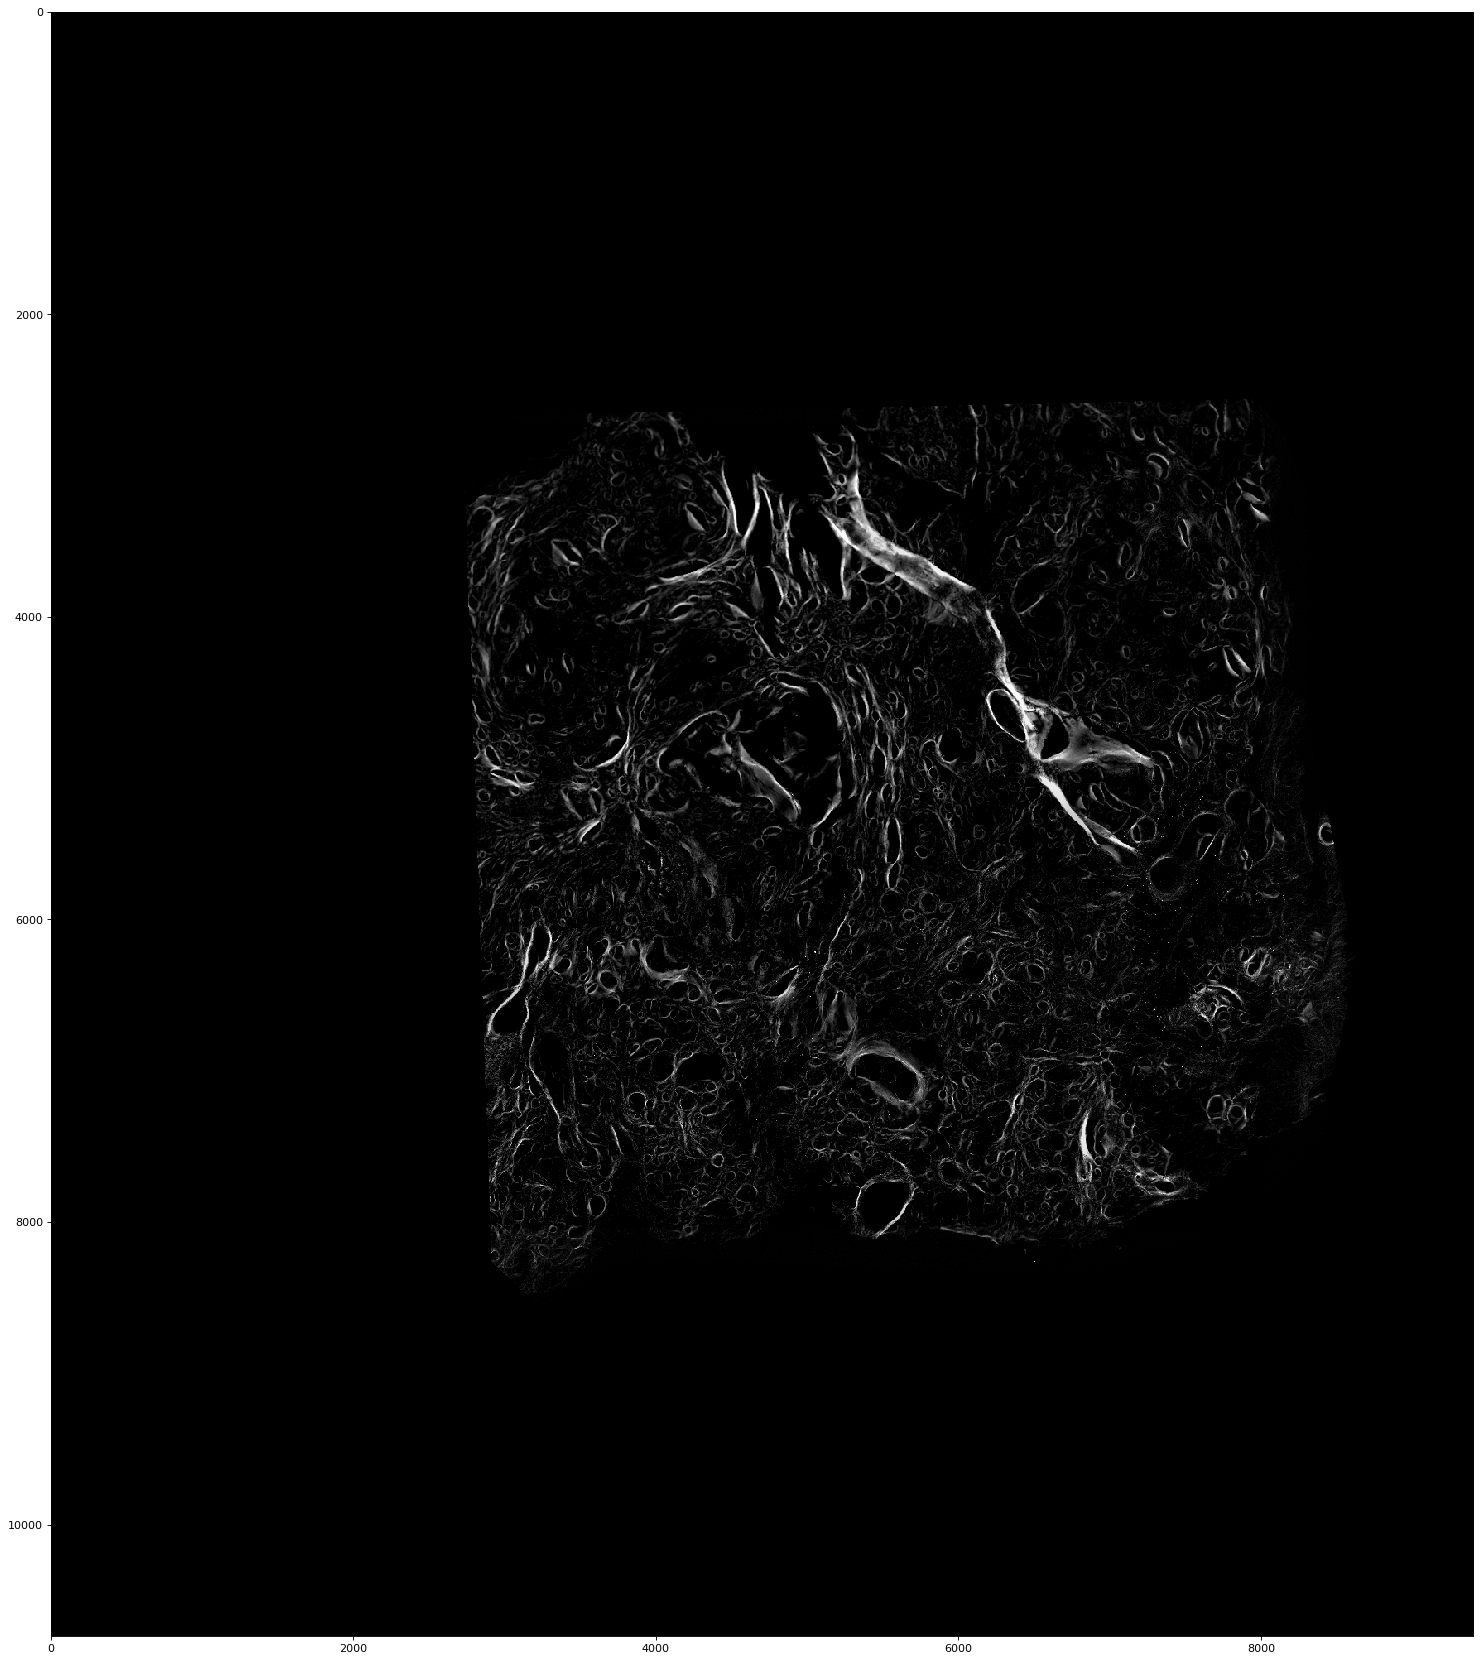

In [98]:
#maskedFixed = sitk.Mask(fixed,fixedMask)
postRegMask = registered > 0
masked_fixed_image = sitk.Mask(fixed,postRegMask)
myshow(masked_fixed_image)

In [99]:
sitk.WriteImage(registered,os.path.join(OutDir,sample+'_RegularStepAffineReg'+'.tif'))

In [100]:
sitk.WriteImage(masked_fixed_image,os.path.join(OutDir,sample+'_maskFix_RegularStepAffineReg'+'.tif'))

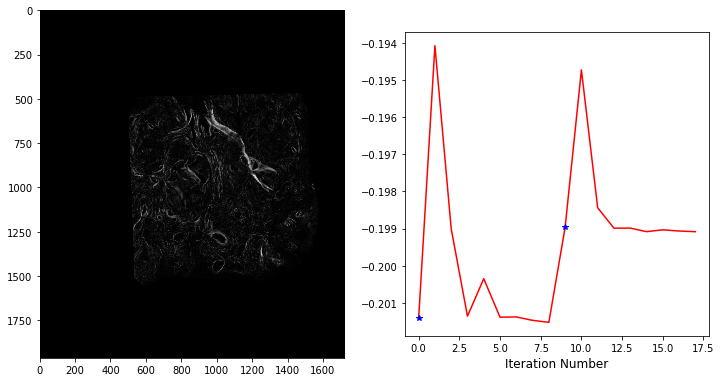

Final metric value: -0.19907708745688374
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 9 iterations. Gradient magnitude (8.28389e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (0000011F10596100)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 363828219
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.988482 -0.0289477 
     0.0279139 0.987034 
   Offset: [46.2496, -62.2461]
   Center: [0, 0]
   Translation: [46.2496, -62.2461]
   Inverse: 
     1.01082 0.0296451 
     -0.0285864 1.0123 
   Singular: 0



In [101]:
(transform2, metric2, stop2) = affine_registration_fineRegister(masked_fixed_image, registered)
print('Final metric value: {0}'.format(metric2))
print('Optimizer\'s stopping condition, {0}'.format(stop2))
print(transform)

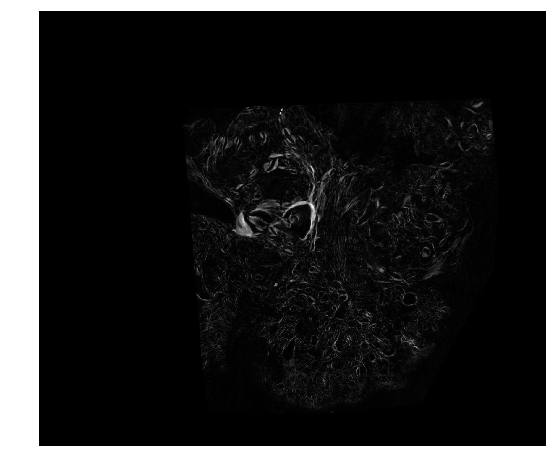

In [88]:
registered2 = sitk.Resample(registered, masked_fixed_image, transform2, sitk.sitkLinear, 0.0, moving.GetPixelID())

display_images_with_alpha(0.7,masked_fixed_image, registered2)


In [89]:
sitk.WriteImage(registered2,os.path.join(OutDir,sample+'_RegularStepAffineReg_RegToMask'+'.tif'))